In [1]:
import imageio as im
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.morphology import(
    grey_dilation,
    binary_opening,
    binary_closing
)
import pickle
import os

## Analysis of the images
The images that must be stitched together form the following grid

In [2]:
base_dir = 'sequencia_1/'
image_names = sorted(os.listdir(base_dir))[1:]
images = list(map(lambda name: im.imread(f'{base_dir}{name}'), image_names))

In [3]:
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
for img, ax in zip(images, np.ravel(axis)):
    ax.imshow(img)

From this simple visual analysis, we can see that detecting keypoints through 
either blob or edge detection would be really dificult, there are no particularly
unique points in those images. That being the case, it is best to ignore the 
content of the images themselves and just look at the background grid to compute
the transformations that can be used to merge all images into a single one 
with minimum overlap. Thus, thresholding is going to be applied to each image 
for the purpose of isolating the grid as a binary image.

## Image stitching
### Thresholding segmentation

Before the thresholding is applied, the images need to be downsampled, otherwise
the computational cost will be too big with the current resolutions.

In [4]:
from src.transformations import downsample_img

downsampled = list(map(lambda img: downsample_img(img, 6), images))

In [5]:
print(downsampled[0].shape)

(458, 640, 3)


In [6]:
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
for img, ax in zip(downsampled, np.ravel(axis)):
    ax.imshow(img)

After performing this downsampling, the images are converted from rgb to 
a grayscale and its color histograms are analyzed

In [7]:
from src.colors import rgb_to_gray
gray_scaled = list(map(rgb_to_gray, downsampled))

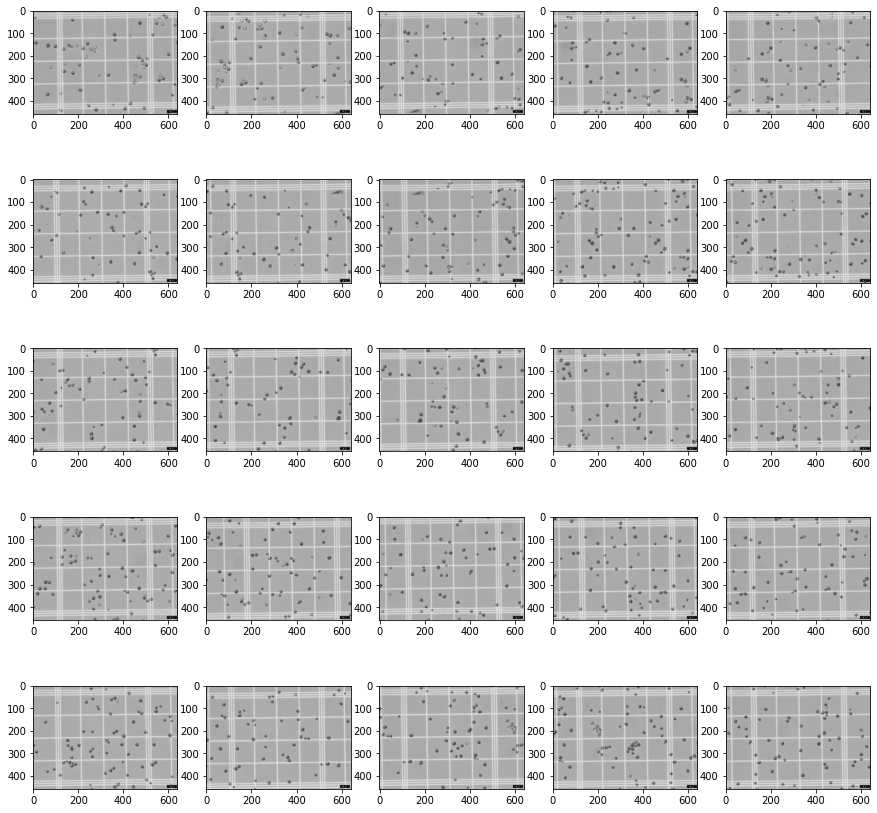

In [8]:
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
for img, ax in zip(gray_scaled, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

In [9]:
raveled = np.ravel(gray_scaled)
freqs, bins = np.histogram(raveled, bins=int(np.max(raveled)), density=True)

<BarContainer object of 255 artists>

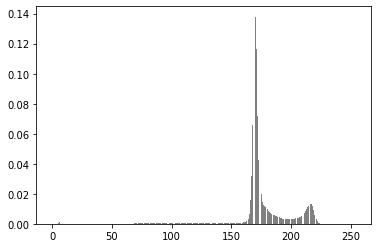

In [10]:
plt.bar(bins[:-1], freqs, color='gray')

With this histogram, it can be seen that since the grid has the brightest color in the monochromatic image, its gray level is probably within the following interval:

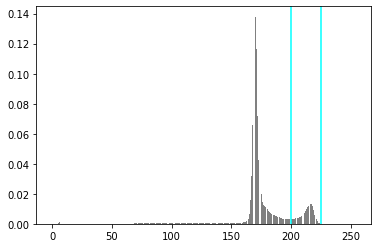

In [11]:
plt.bar(bins[:-1], freqs, color='gray')
plt.axvline(200, color='cyan')
plt.axvline(225, color='cyan')

To find the probability associated with this interval, we compute the cumulative
histogram and obtain the following percentile as a threshold

In [12]:
plt.bar(bins[:-1], list(np.add.accumulate(freqs) / np.sum(freqs)), color='gray')
plt.axvline(200, color='cyan')
plt.axvline(220, color='cyan')
plt.axhline(y=0.85, color='red')

Now, thresholding the images to values higher than the 85th percentile results in

In [13]:
from src.transformations import threshold
thresholded = list(map(lambda img: threshold(img, 0.85), gray_scaled))

In [14]:
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
for img, ax in zip(thresholded, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

Which properly isolates the grid. But with a closer inspection, we can see that
it ends up leaving a good number of imperfections on the grid lines

In [15]:
fig, axis = plt.subplots(1, figsize=(8, 8))
plt.imshow(thresholded[0], cmap='gray')

### Correcting rotation

Now that the grid has been isolated, we have that the textura along its rows
$f_i$ can described through the maximum probability value $\max_\{P_{f_i}\}$
in its color histogram $P_{f_i}$, or in other words, the measure of how much
participation the dominant color has in the row. We also have that the distance
between any two row texture descriptors $P_g$ and $P_h$ can be calculated as
$$|P_g - P_h|.$$ 

When a grid horizontal $P_i$ line is perfectly aligned with the axis, the dominant
color of the rows that represent it should have a histogram with a probability
of each pixel in that row having value one very close to the maximum. For rows
that do not represent horizontal lines, in an ideal thresholded grid image,
there should be a negligeble probability $c$ that a pixel has value zero 
(part of a vertical line) and a probability $1 - c$ that a pixel has value one.

In this case, $P_i - P_g$ will be positive for any rotated lien and approximately
0 otherwise. This makes this distance function almost linear, so $c$ is ignored,
and the row texture descriptor of an ideal thresholded grid image that is aligned
with the xy-axis is defined as row in which the color histogram has a maximum
probability value of one. Now using this row texture as a reference point, we
minimize the sum of the distances between the row textures of an image and the
row textures of an ideal grid through iterative rotations to obtain an estimator
of the angle that must be used by a rotation to align the image lines to the x axis. 

In [16]:
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate

def binary_value_max_probability(array):
    probability_of_1 = np.sum(array) / np.prod(array.shape)
    return max(probability_of_1, 1 - probability_of_1)

def loss_function(img):
    row_max_probabilites = [binary_value_max_probability(row) for row in img]
    return img.shape[0] - np.sum(row_max_probabilites)

def correct_image_rotation_angle(img):
    def rotation(ang):
        return loss_function(rotate(img, angle=ang))
    result = minimize_scalar(rotation, tol=1e-8)
    return result.x

In [17]:
angles = list(map(correct_image_rotation_angle, thresholded))

In [18]:
from itertools import starmap

def configured_rotation(img, angle):
    return rotate(img, angle, mode='reflect', reshape=False)

rotation_corrected = list(starmap(configured_rotation, zip(gray_scaled, angles)))

From that, the following results are obtained

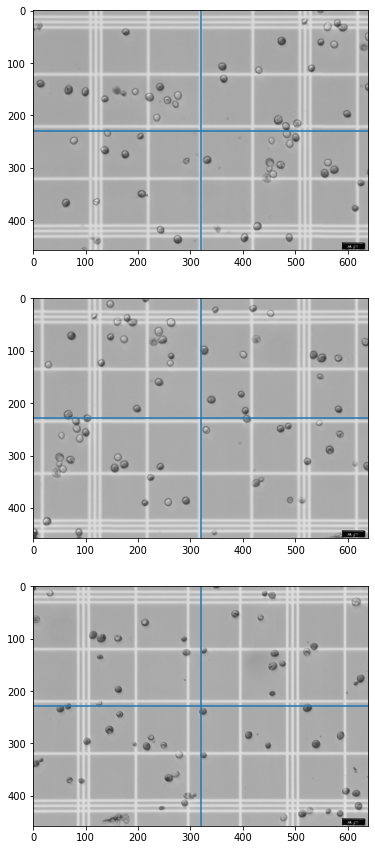

In [19]:
fig, axis = plt.subplots(3, figsize=(15, 15))
for img, ax in zip(rotation_corrected[:3], np.ravel(axis)[:3]):
    ax.imshow(img, cmap='gray')
    ax.axhline(img.shape[0] // 2)
    ax.axvline(img.shape[1] // 2)

### Key points detection

Now, for the key points detection, since the images don't have a lot of 
distinguishing features, the idea is to use the grid to detect the points 
that can be matched to the adjacent images, more precisely, the four groups of
three lines that are very close together can be used to estimate four corner
points on the image that can be matched to other images through ther spatial 
positions on the images. 

To find those points, we must first blurr the image so that the three lines that
are close together get merged into a single rectangle. For that a gaussian 
filter is applyed before thresholding for a lower percentile

In [20]:
from src.filters import apply_gaussian

blurred = list(map(lambda img: apply_gaussian(img, 3), rotation_corrected))
thresholded = list(map(lambda img: threshold(img, 0.7), blurred))

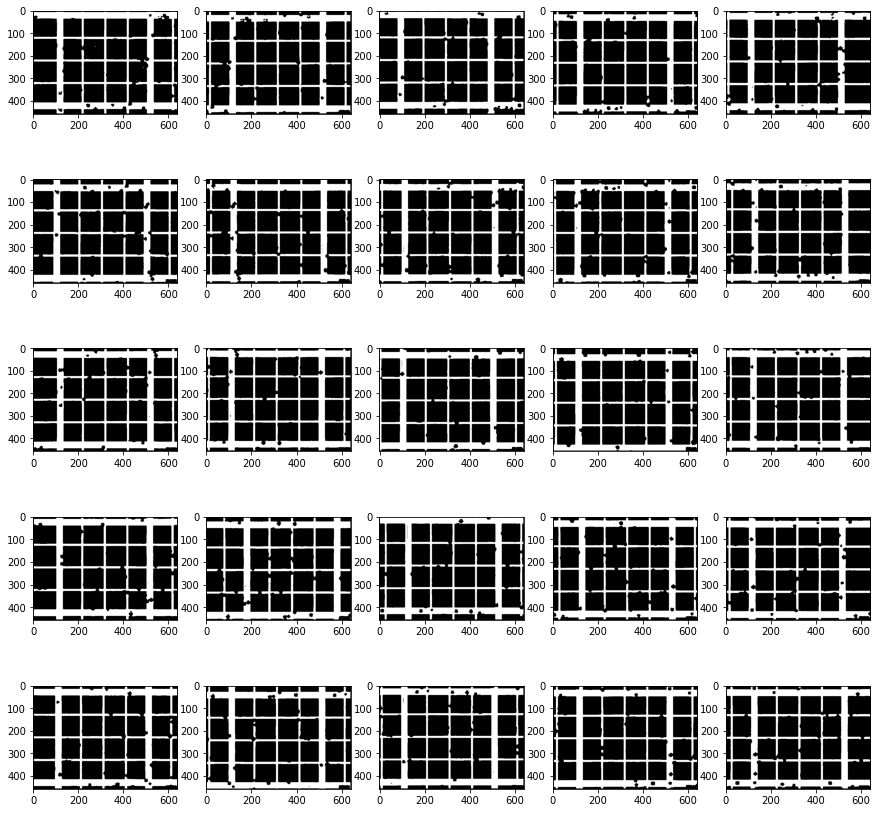

In [21]:
fig, axis = plt.subplots(5,5, figsize=(15, 15))
for img, ax in zip(thresholded, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

Now, thresholding the row and column percentages of white pixels to detect lines,
we can find the two biggest areas of rows of the image filled with white pixels and
estimate their centers. The same thing can be done for the image columns. After
detecting those centers, their intersections give a very good estimate of the
corners of the central big square

In [22]:
from src.stitching import find_major_grid_corners

corners = list(map(find_major_grid_corners, thresholded))

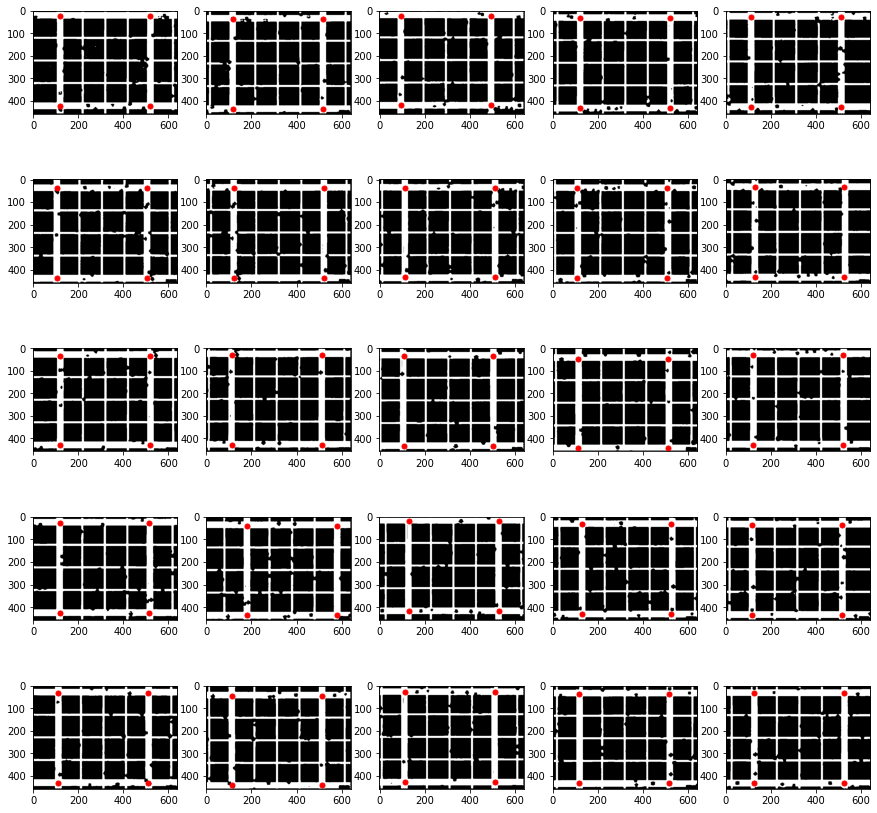

In [23]:
fig, axis = plt.subplots(5,5, figsize=(15, 15))
for img, ax, corn in zip(thresholded, np.ravel(axis), corners):
    x, y = zip(*np.vstack(corn))
    ax.imshow(img, cmap='gray')
    ax.plot(y, x, color='red', marker='o', linestyle='None', markersize=5)

Then computing the transformations that allow us to stitch them together, we
obtain the following results

In [24]:
from src.stitching import stitch_images
img_grid = [
    downsampled[:5],
    downsampled[5:10],
    downsampled[10:15],
    downsampled[15:20],
    downsampled[20:25],
]
result = stitch_images(img_grid)

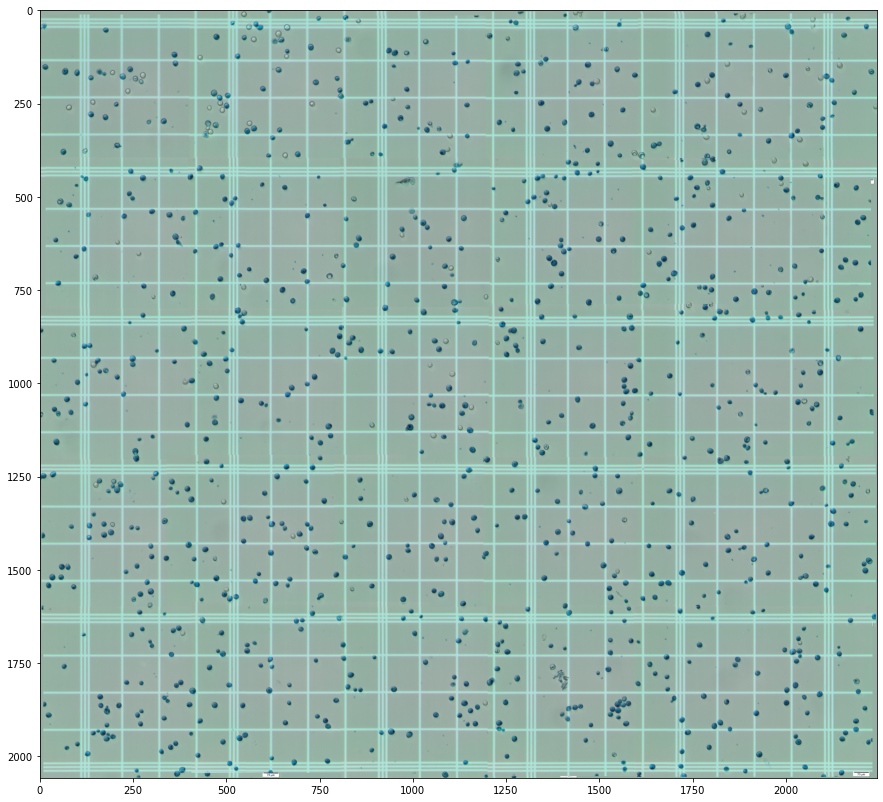

In [25]:
fig, axis = plt.subplots(1, figsize=(15, 15))
axis.imshow(result)

## Cell detection

After stitching the grid of images into a single image, the cells must be 
detected within it. To do that, since the cells have a circular shape, circle
detection is going to be used.

In [26]:
image = result

### Gabor Annulus

This circle detection is performed by applying a Gabor Annulus filter to the 
image. This filter can be described by the following two equations

$G(r) = \frac{1}{2 \pi \sigma r_0}
e^{-\pi\left[\frac{(r-r_0)^2}{\sigma^2}\right]}e^{i2\pi f_0(r-r_0)}$

$r = \sqrt{{(x - x_0)}^2 {(y-y_0)}^2}$

and their visualization gives us

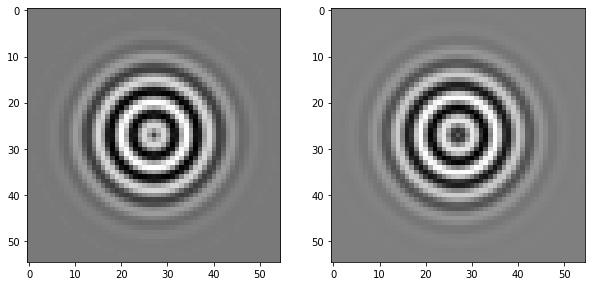

In [27]:
from src.filters import create_gabor_annulus_kernel, apply_gabor_annulus
a = create_gabor_annulus_kernel(55, 7, 15, 1 / 5)
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].imshow(a.real, cmap='gray')
axis[1].imshow(a.imag, cmap='gray')

After convolving it with the red channel of the image (The red channel is the 
one in which the cells are better highlighted) and taking the absolute values
of the complex evaluations of the image after this operation, it is possible
to see that the centers of the potetntial cells are depicted as particularly
bright points in the following heat map

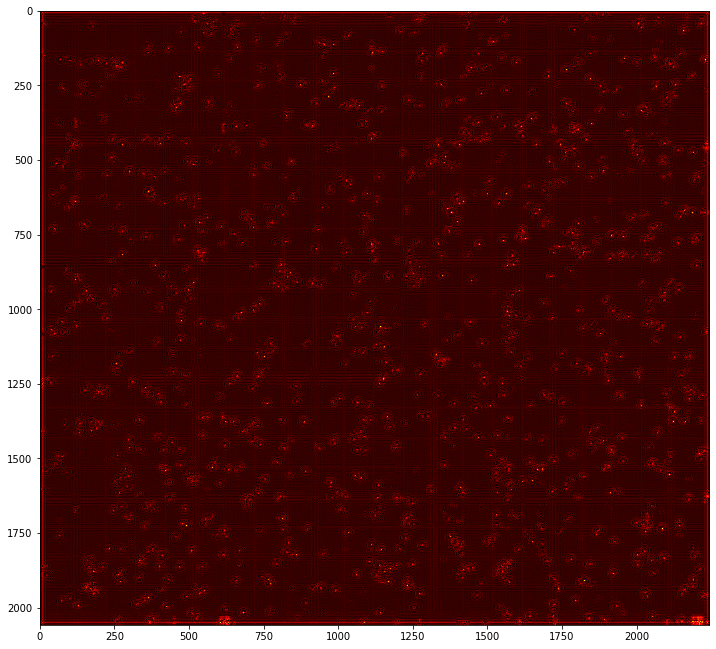

In [28]:
centers_likelihood = np.abs(apply_gabor_annulus(image[:,:,0], 55, 7, 15, 1 / 5))
fig, axis = plt.subplots(1, figsize=(12, 12))
axis.imshow(centers_likelihood, cmap='hot', interpolation='nearest')

By looking at this image, it can be seen that through it the centers can be
detected through non maximum suppression an hysteresis threshold but the problem
is that together with the cells, there is still some noise from the background
grid and from the small white rectangles. 


This could interfere with the detection, so before applying the gabor annulus, 
the image is dilated with the following structure to obtain a binary mask that
will allow us to substitute the white color for the standard background color 
of the image.

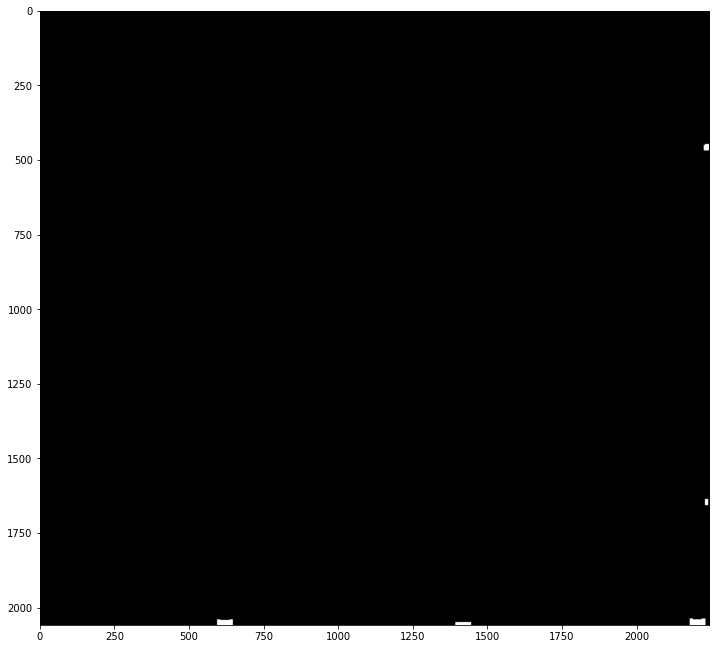

In [29]:
structure = np.ones((11, 11), dtype=np.uint8)
white_rectangle_dilation = grey_dilation(image[:,:,0], footprint=structure)
white_rectangle_mask = white_rectangle_dilation > 250
fig, axis = plt.subplots(1, figsize=(12, 12))
axis.imshow(np.uint8(white_rectangle_mask), cmap='gray')

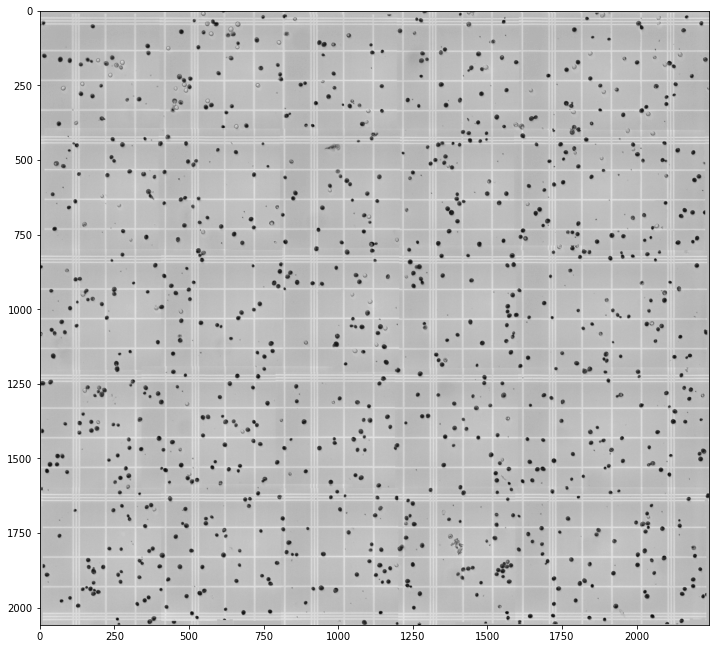

In [30]:
new_image = np.copy(image[:,:,0])
new_image[white_rectangle_mask] = np.median(new_image)

fig, axis = plt.subplots(1, figsize=(12, 12))
axis.imshow(new_image, cmap='gray')

After getting rid of the white rectangle, it is necessary to deal with the noise
caused by the background grid. For that, the magnitude of the gradient is 
thresholded to obtain the edges of the cells. Then, a close operation is executed
on the binary image with a big disk structure and, afterwards, a closing operation
is performed with a small disk structure to eliminate points that are too small
to be a circle. This way, we obtain the following binary mask.

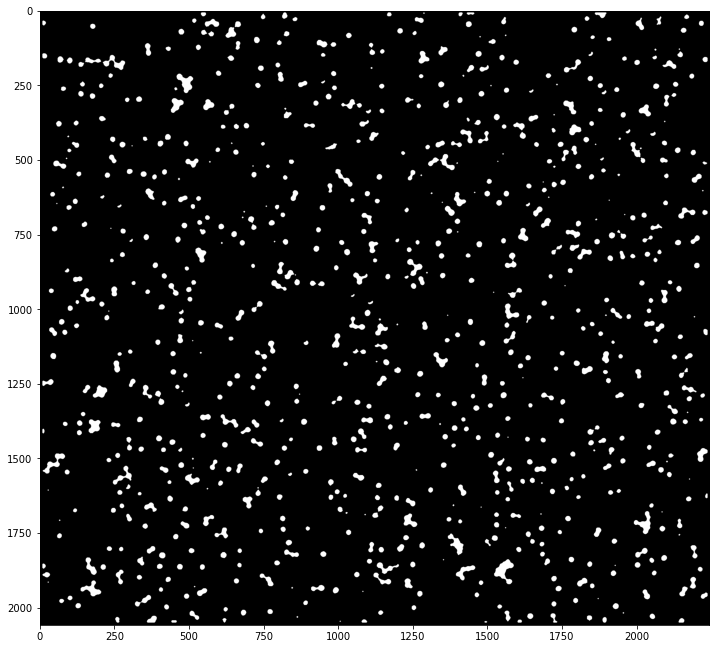

In [31]:
from src.cell_detection import threshold_cells
thresholded_cells = threshold_cells(new_image)
fig, axis = plt.subplots(1, figsize=(12, 12))
axis.imshow(thresholded_cells, cmap='gray')

Which when multiplied by the result from the convolution of the gabor anulus and
the image without the white rectangle, returns only the regions that are of 
interest for the circle detection

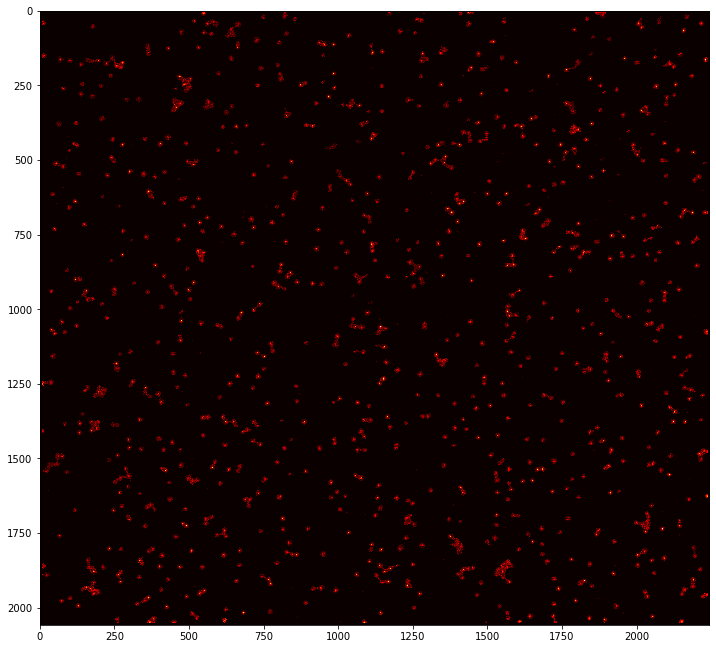

In [32]:
center_regions = thresholded_cells * np.abs(apply_gabor_annulus(image[:,:,0], 55, 7, 15, 1 / 5))
fig, axis = plt.subplots(1, figsize=(12, 12))
axis.imshow(center_regions, cmap='hot', interpolation='nearest')

Thus, after applying non max suppression, hysteresis threshold and filtering
excessive overlays, we obtain the following detected cells

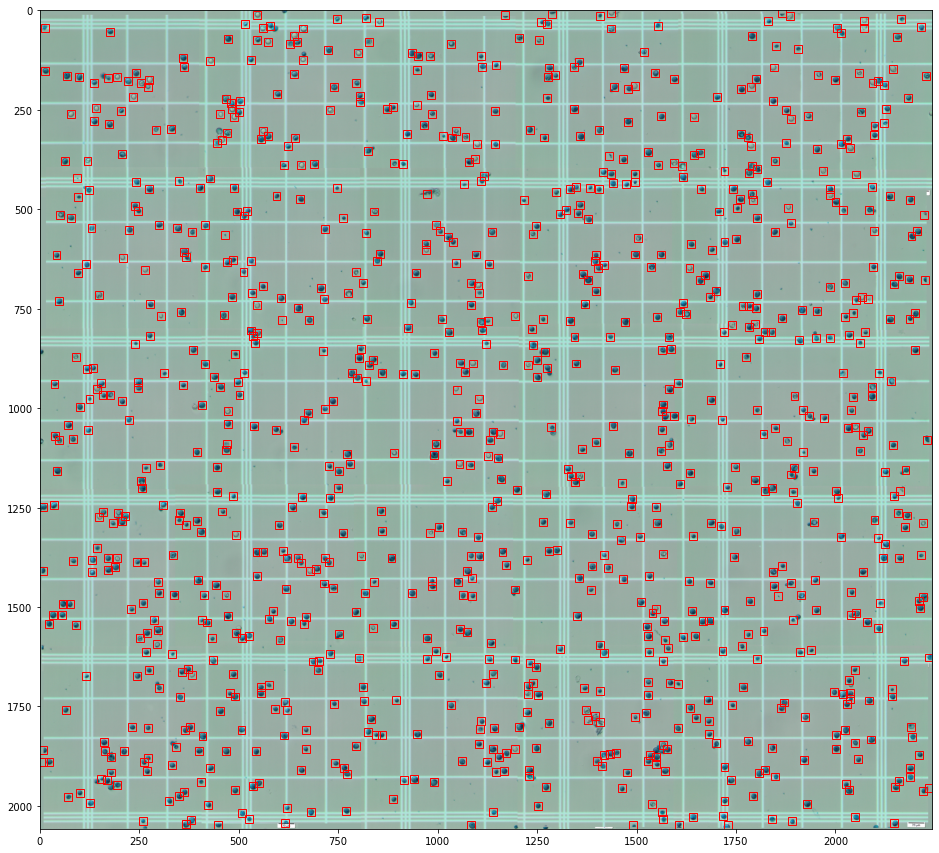

In [33]:
from src.cell_detection import detect_cells
centers = detect_cells(image)

fig, axis = plt.subplots(1, figsize=(16, 16))
axis.imshow(image)
for x, y in centers:
    axis.add_patch(patches.Rectangle((y-10, x-10), 20, 20, edgecolor='r', facecolor='none'))

## Cell classification

After detecting the cells, since the feature that better distinguishes the 
different cells is their color, only the mean pixel value of each RGB channel is 
utilized to build a features vector that represents how much each channel 
participates in the color of the cell. For that each features vector is divided
by the sum of its components.

This mean pixel value is taken over a window of radius 2 to make sure that the 
background colors aren't being too expressive on the values for smaller cells.
That is also the reason why a complete color histogram isn't utilized. The 
histogram would take into acoount the colors that are present in the background
and thus would end up adding noise to the feature we actually want to use for 
classification. 

For the classification algorithm, k-means cluster is utilized. To train it, the 
image formed by the grid stored in sequencia_1 is used as a training set and 
the test is done on the cells of the image taken from sequencia_2.

This way, in the end, the following results are obtained

In [34]:
from src.cell_classification import classify_cells
with open("classifier.pkl", "rb") as f:
    classifier = pickle.load(f)
with open("label_meanings.pkl", "rb") as f:
    label_meanings = pickle.load(f)

labels, metrics = classify_cells(image, centers, model=classifier)

label1, label1_points, label1_silhouette = metrics[0]
label2, label2_points, label2_silhouette = metrics[1]
total_points = label1_points + label2_points
label1_probability = np.round(100 * label1_points / total_points, 2)
label2_probability = np.round(100 * label2_points / total_points, 2)
print('----------------------------------------------')
print(f'Estimated {label1_points} ({label1_probability}%) {label_meanings[label1]}')
print(f'Silhouette coefficient: {label1_silhouette}')
print('----------------------------------------------')
print(f'Estimated {label2_points} ({label2_probability}%) {label_meanings[label2]}')
print(f'Silhouette coefficient: {label2_silhouette}')

----------------------------------------------
Estimated 838 (84.73%) Dead cells
Silhouette coefficient: 0.7255728855941194
----------------------------------------------
Estimated 151 (15.27%) Healthy cells
Silhouette coefficient: 0.6717842143644754


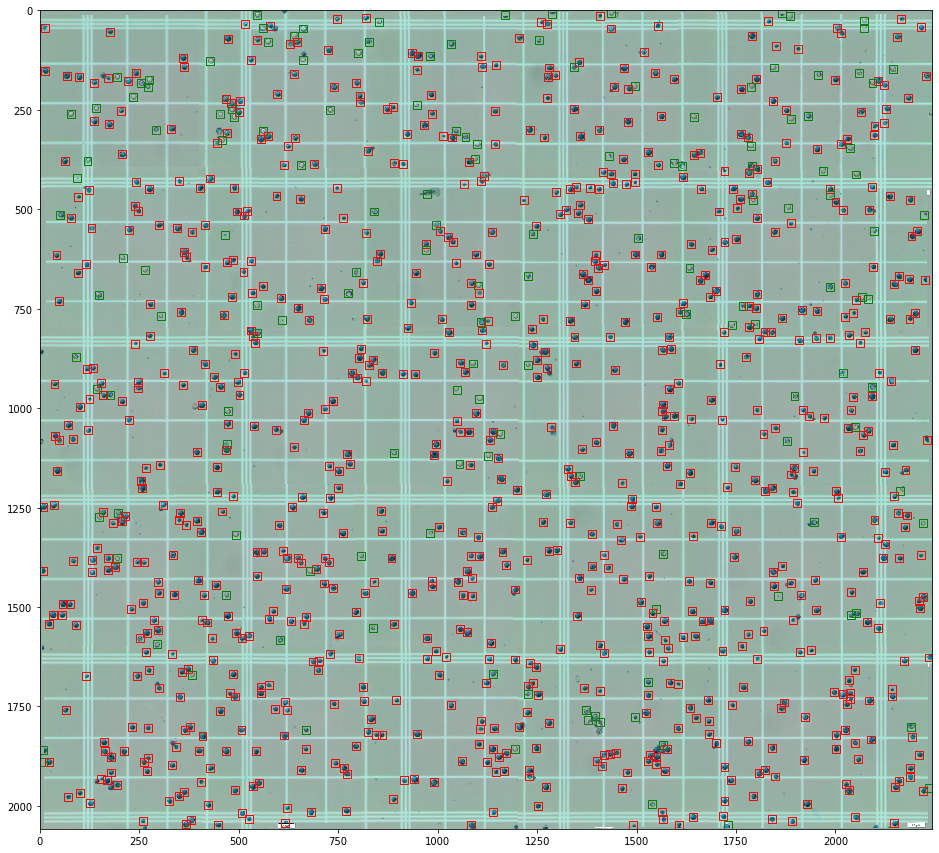

In [35]:
fig, axis = plt.subplots(1, figsize=(16, 16))
axis.imshow(image, interpolation='nearest')

colors = ['r', 'g']

for i, (x, y) in enumerate(centers):
    color = colors[labels[i]]
    axis.add_patch(patches.Rectangle((y-10, x-10), 20, 20, edgecolor=color, facecolor='none'))

It can be seen that almost all cells were detected and even though some dead
cells were recognized as alive cells, for the most part, the classification 
also obtained acceptable results.